<a href="https://colab.research.google.com/github/NavinThomsy/IAT885-Final-Project/blob/IAT885_test_branch/IAT885_Final_CV_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description






Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

    - Apple

    - Banana

    - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [3]:
test_dir = '/content/drive/MyDrive/FootballEvents3/test'
train_dir = '/content/drive/MyDrive/FootballEvents3/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

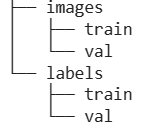


Making directories according to above struture of folders

In [4]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/images')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/labels')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/FootballEvents3/Final_data/labels/val')

In [5]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/FootballEvents3/Final_data/labels"
image_dir="/content/drive/MyDrive/FootballEvents3/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.

In [6]:
#import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

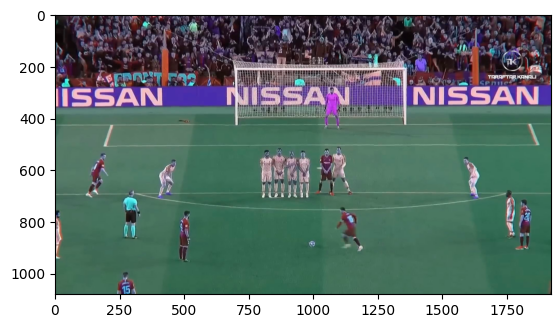

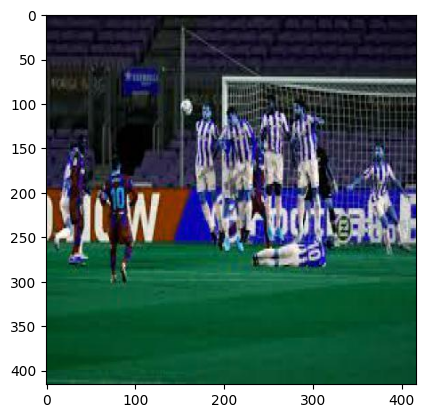

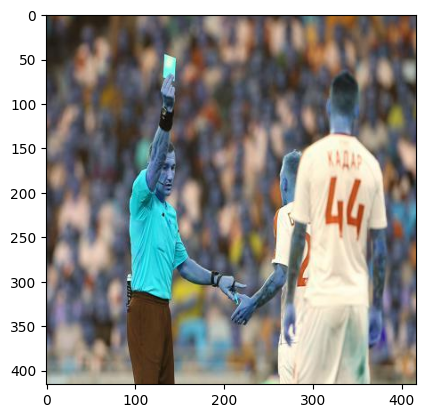

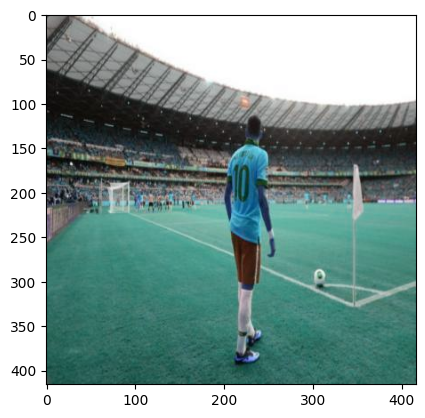

In [7]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [8]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Streaming output truncated to the last 5000 lines.
<Element 'metadata' at 0x786ae9d17010>
<Element 'tags' at 0x786ae9d15990>
<Element 'tag' at 0x786ae9d159e0>
/content/drive/MyDrive/FootballEvents3/Final_data/labels/train/37_jpg.rf.40759e6febe48f3e3364b6cb9822c40a.xml
<Element 'annotation' at 0x786ae9d29440>
<Element 'folder' at 0x786ae9d28770>
<Element 'filename' at 0x786ae9d28ea0>
<Element 'path' at 0x786ae9d2bbf0>
<Element 'source' at 0x786ae9d2a980>
<Element 'database' at 0x786ae9d299e0>
<Element 'size' at 0x786ae9d2a750>
<Element 'width' at 0x786ae9d2bd80>
<Element 'height' at 0x786ae9d2bf10>
<Element 'depth' at 0x786ae9d29940>
<Element 'segmented' at 0x786aed711800>
<Element 'object' at 0x786ae9d15ee0>
<Element 'name' at 0x786ae9d15a80>
<Element 'pose' at 0x786ae9d14ae0>
<Element 'truncated' at 0x786ae9d17f60>
<Element 'difficult' at 0x786ae9d157b0>
<Element 'occluded' at 0x786ae9d167f0>
<Element 'bndbox' at 0x786ae9d17240>
<Element 'xmin' at 0x786ae9d16570>
<Element 'xmax' at 0x

Doing the same for validation data labels.


In [9]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

In [10]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

name         label  width  \
0  yt-7XNVfNj2h0-0630_jpg.rf.4f95620ebff1670a0a5f...      shooting    640   
1         29_jpg.rf.bedbbead1be0fde8fbccf89f9f585ca1      shooting    416   
2         27_jpg.rf.46ff52cc23f7d2125949cefa53a3355e     free-kick    416   
3          4_jpg.rf.8e5a5c8b74538f74fdd4c0d787847d17  substitution    416   
4  yt-ZWi9LLNHk90-0718_jpg.rf.19d082bf3e04e5b83d3...   yellow-card   1920   

   height  xmin  ymin  xmax  ymax  
0     360    51    54   230   316  
1     416   207    44   388   416  
2     416   167     1   357   415  
3     416     1     9   184   151  
4    1080  1080    46  1254   195

Visualizing one of the image in train set with the bounding box

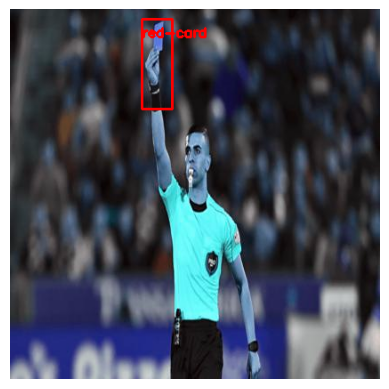

In [11]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

In [12]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

                                              name     label  width  height  \
10  39_png_jpg.rf.c2fe1b15970c6eadc25dac60b6eebd9e  red-card    416     416   

    xmin  ymin  xmax  ymax  
10   148    11   182   112  


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [13]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    64 non-null     object
 1   label   64 non-null     object
 2   width   64 non-null     int64 
 3   height  64 non-null     int64 
 4   xmin    64 non-null     int64 
 5   ymin    64 non-null     int64 
 6   xmax    64 non-null     int64 
 7   ymax    64 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 4.1+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [14]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['yellow-card' 'red-card' 'substitution' 'corner-kick' 'free-kick'
 'shooting']
['shooting' 'free-kick' 'substitution' 'yellow-card' 'red-card'
 'corner-kick']


We need to map labels to class_ids required for YOLO

In [15]:
label_map = { 'substitution': 0,
            'red-card': 1,
            'corner-kick': 2,
              'yellow-card': 3,
              'free-kick': 4,
              'shooting': 5}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [16]:
train_df.head()

name         label  width  \
0    62_jpeg_jpg.rf.7d59a4f02e2f1cfc158496daa178ef41   yellow-card    416   
1  yt-ZWi9LLNHk90-1359_jpg.rf.a75fe5fb7734ad83807...   yellow-card   1920   
2  yt-cH6w7u9wMkk-1088_jpg.rf.f8584a89b814647401f...      red-card   1920   
3    52_jpeg_jpg.rf.edd685c6091328bb159ab69a60877070  substitution    416   
4    57_jpeg_jpg.rf.9558afcb80483f8b5217cda2653ba517   yellow-card    416   

   height  xmin  ymin  xmax  ymax  class  
0     416   193    29   233   186      3  
1    1080   832   212   983   397      3  
2    1080  1182   273  1308   432      1  
3     416    61     1   368   266      0  
4     416   133   134   285   416      3

convertig the bounding box format to the one required by YOLO:




In [17]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [18]:
train_df.head()

name         label  width  \
0    62_jpeg_jpg.rf.7d59a4f02e2f1cfc158496daa178ef41   yellow-card    416   
1  yt-ZWi9LLNHk90-1359_jpg.rf.a75fe5fb7734ad83807...   yellow-card   1920   
2  yt-cH6w7u9wMkk-1088_jpg.rf.f8584a89b814647401f...      red-card   1920   
3    52_jpeg_jpg.rf.edd685c6091328bb159ab69a60877070  substitution    416   
4    57_jpeg_jpg.rf.9558afcb80483f8b5217cda2653ba517   yellow-card    416   

   height  xmin  ymin  xmax  ymax  class  x_center  y_center  box_width  \
0     416   193    29   233   186      3  0.512019  0.258413   0.096154   
1    1080   832   212   983   397      3  0.472656  0.281944   0.078646   
2    1080  1182   273  1308   432      1  0.648438  0.326389   0.065625   
3     416    61     1   368   266      0  0.515625  0.320913   0.737981   
4     416   133   134   285   416      3  0.502404  0.661058   0.365385   

   box_height  
0    0.377404  
1    0.171296  
2    0.147222  
3    0.637019  
4    0.677885

Deleting all the sample with Nan values in training and validation data

In [19]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (520, 13)
after deleting(train_data):  (520, 13)
before deleting (val data):  (64, 13)
after deleting(val data):  (64, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [20]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [21]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

name        label width height  \
100  76_jpg.rf.2246856f663dba4fcf8f7314ade153fa  yellow-card   416    416   

    xmin ymin xmax ymax class            x_center             y_center  \
100  248    1  284   83     3  0.6394230769230769  0.10096153846153846   

               box_width          box_height  
100  0.08653846153846154  0.1971153846153846

In [22]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [23]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [24]:
print(len(image_files_val), "  =  ", len(label_files_val))

63   =   58


In [25]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): {'yt-7XNVfNj2h0-0091_jpg', 'yt-4z6oCZVAPuI-0053_jpg', 'yt-4z6oCZVAPuI-0132_jpg', 'yt-4z6oCZVAPuI-0084_jpg', 'yt-4z6oCZVAPuI-0039_jpg', 'yt-4z6oCZVAPuI-0063_jpg', 'yt-4z6oCZVAPuI-0015_jpg', 'yt-4z6oCZVAPuI-0077_jpg', 'yt-4z6oCZVAPuI-0082_jpg', 'yt-4z6oCZVAPuI-0046_jpg', 'yt-4z6oCZVAPuI-0047_jpg', 'yt-4z6oCZVAPuI-0196_jpg', 'yt-4z6oCZVAPuI-0069_jpg', 'yt-4z6oCZVAPuI-0081_jpg', 'yt-4z6oCZVAPuI-0074_jpg', 'yt-4z6oCZVAPuI-0051_jpg', 'yt-4z6oCZVAPuI-0085_jpg', 'yt-P04igAlsw2Q-0329_jpg', 'yt-4z6oCZVAPuI-0050_jpg', 'yt-4z6oCZVAPuI-0075_jpg', 'yt-4z6oCZVAPuI-0169_jpg', 'yt-4z6oCZVAPuI-0026_jpg', 'yt-4z6oCZVAPuI-0054_jpg', 'yt-4z6oCZVAPuI-0066_jpg', 'yt-4z6oCZVAPuI-0043_jpg', 'yt-4z6oCZVAPuI-0028_jpg', 'yt-4z6oCZVAPuI-0086_jpg', 'yt-4z6oCZVAPuI-0034_jpg', 'yt-4z6oCZVAPuI-0170_jpg', 'yt-4z6oCZVAPuI-0014_jpg', 'yt-4z6oCZVAPuI-0079_jpg', 'yt-4z6oCZVAPuI-0057_jpg', 'yt-4z6oCZVAPuI-0016_jpg', 'yt-7XNVfNj2h0-0061_jpg'}
Training Extra labels (withou

Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
# for file in extra_images_train:
#      os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

# for file in extra_images_val:
#      os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [26]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.1/78.2 GB disk)


In [27]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [28]:
model = YOLO('yolov8l.pt') # pretrained model

100%|██████████| 83.7M/83.7M [00:00<00:00, 358MB/s]


The detailed architecture of the model can be seen from:


In [29]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_r

In [30]:
%%writefile config.yaml
path: /content/drive/MyDrive/FootballEvents3/Final_data
train: /content/drive/MyDrive/FootballEvents3/Final_data/images/train
test: /content/drive/MyDrive/FootballEvents3/Final_data/images/test
val: /content/drive/MyDrive/FootballEvents3/Final_data/images/val

# Classes
nc: 6 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: substitution
  1: red-card
  2: corner-kick
  3: yellow-card
  4: free-kick
  5: shooting

Writing config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [31]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              


  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 6.23M/6.23M [00:00<00:00, 326MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/train... 519 images, 34 backgrounds, 0 corrupt: 100%|██████████| 553/553 [00:07<00:00, 75.44it/s] 


train: New cache created: /content/drive/MyDrive/FootballEvents3/Final_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:01<00:00, 57.61it/s]


val: New cache created: /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.05G      1.697      3.643      1.777          2        640: 100%|██████████| 70/70 [00:31<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

                   all         68         64      0.021      0.128     0.0354     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.25G      1.821      3.311      1.905          3        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]

                   all         68         64      0.252      0.441      0.106     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.29G      1.877      3.206      2.014          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

                   all         68         64     0.0127      0.243    0.00712    0.00249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.25G      1.786      2.881      1.965          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

                   all         68         64      0.208      0.368      0.271      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.28G      1.636      2.528      1.848          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all         68         64      0.419      0.547      0.433      0.216



5 epochs completed in 0.049 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68         64       0.42      0.547      0.433      0.216
          substitution         68          8      0.584        0.5      0.591      0.391
              red-card         68         13      0.598      0.692      0.687      0.265
           corner-kick         68          9       0.39      0.333      0.379      0.181
           yellow-card         68          7      0.493      0.557      0.397      0.175
             free-kick         68         16      0.342      0.562      0.396      0.226
              shooting         68         11       0.11      0.636      0.147     0.0575
Speed: 0.4ms preprocess, 19.0ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7869a7d012a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [32]:
metrics = model.val()  # no arguments needed, dataset and settings remembered


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


                   all         68         64      0.418      0.548      0.428      0.214
          substitution         68          8      0.584        0.5      0.591      0.391
              red-card         68         13      0.593      0.692      0.671      0.257
           corner-kick         68          9      0.388      0.333      0.366       0.18
           yellow-card         68          7      0.495      0.561      0.395      0.175
             free-kick         68         16      0.341      0.562      0.395      0.225
              shooting         68         11      0.109      0.636      0.147     0.0572
Speed: 1.1ms preprocess, 44.1ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


In [33]:
metrics.box.map    # map50-95

0.21423278949360386

In [34]:
metrics.box.map50  # map50

0.42756610787141064

In [35]:
metrics.box.map75  # map75

0.1718796662566349

In [36]:
metrics.box.maps   # a list contains map50-95 of each category

array([    0.39146,     0.25665,     0.17995,     0.17524,     0.22484,    0.057244])

In [37]:
metrics.box.mp    # P

0.41810803523124723

In [38]:
metrics.box.mr    # R

0.5475113827238068

Showing confusion matrix, that is already stored in detect/train folder

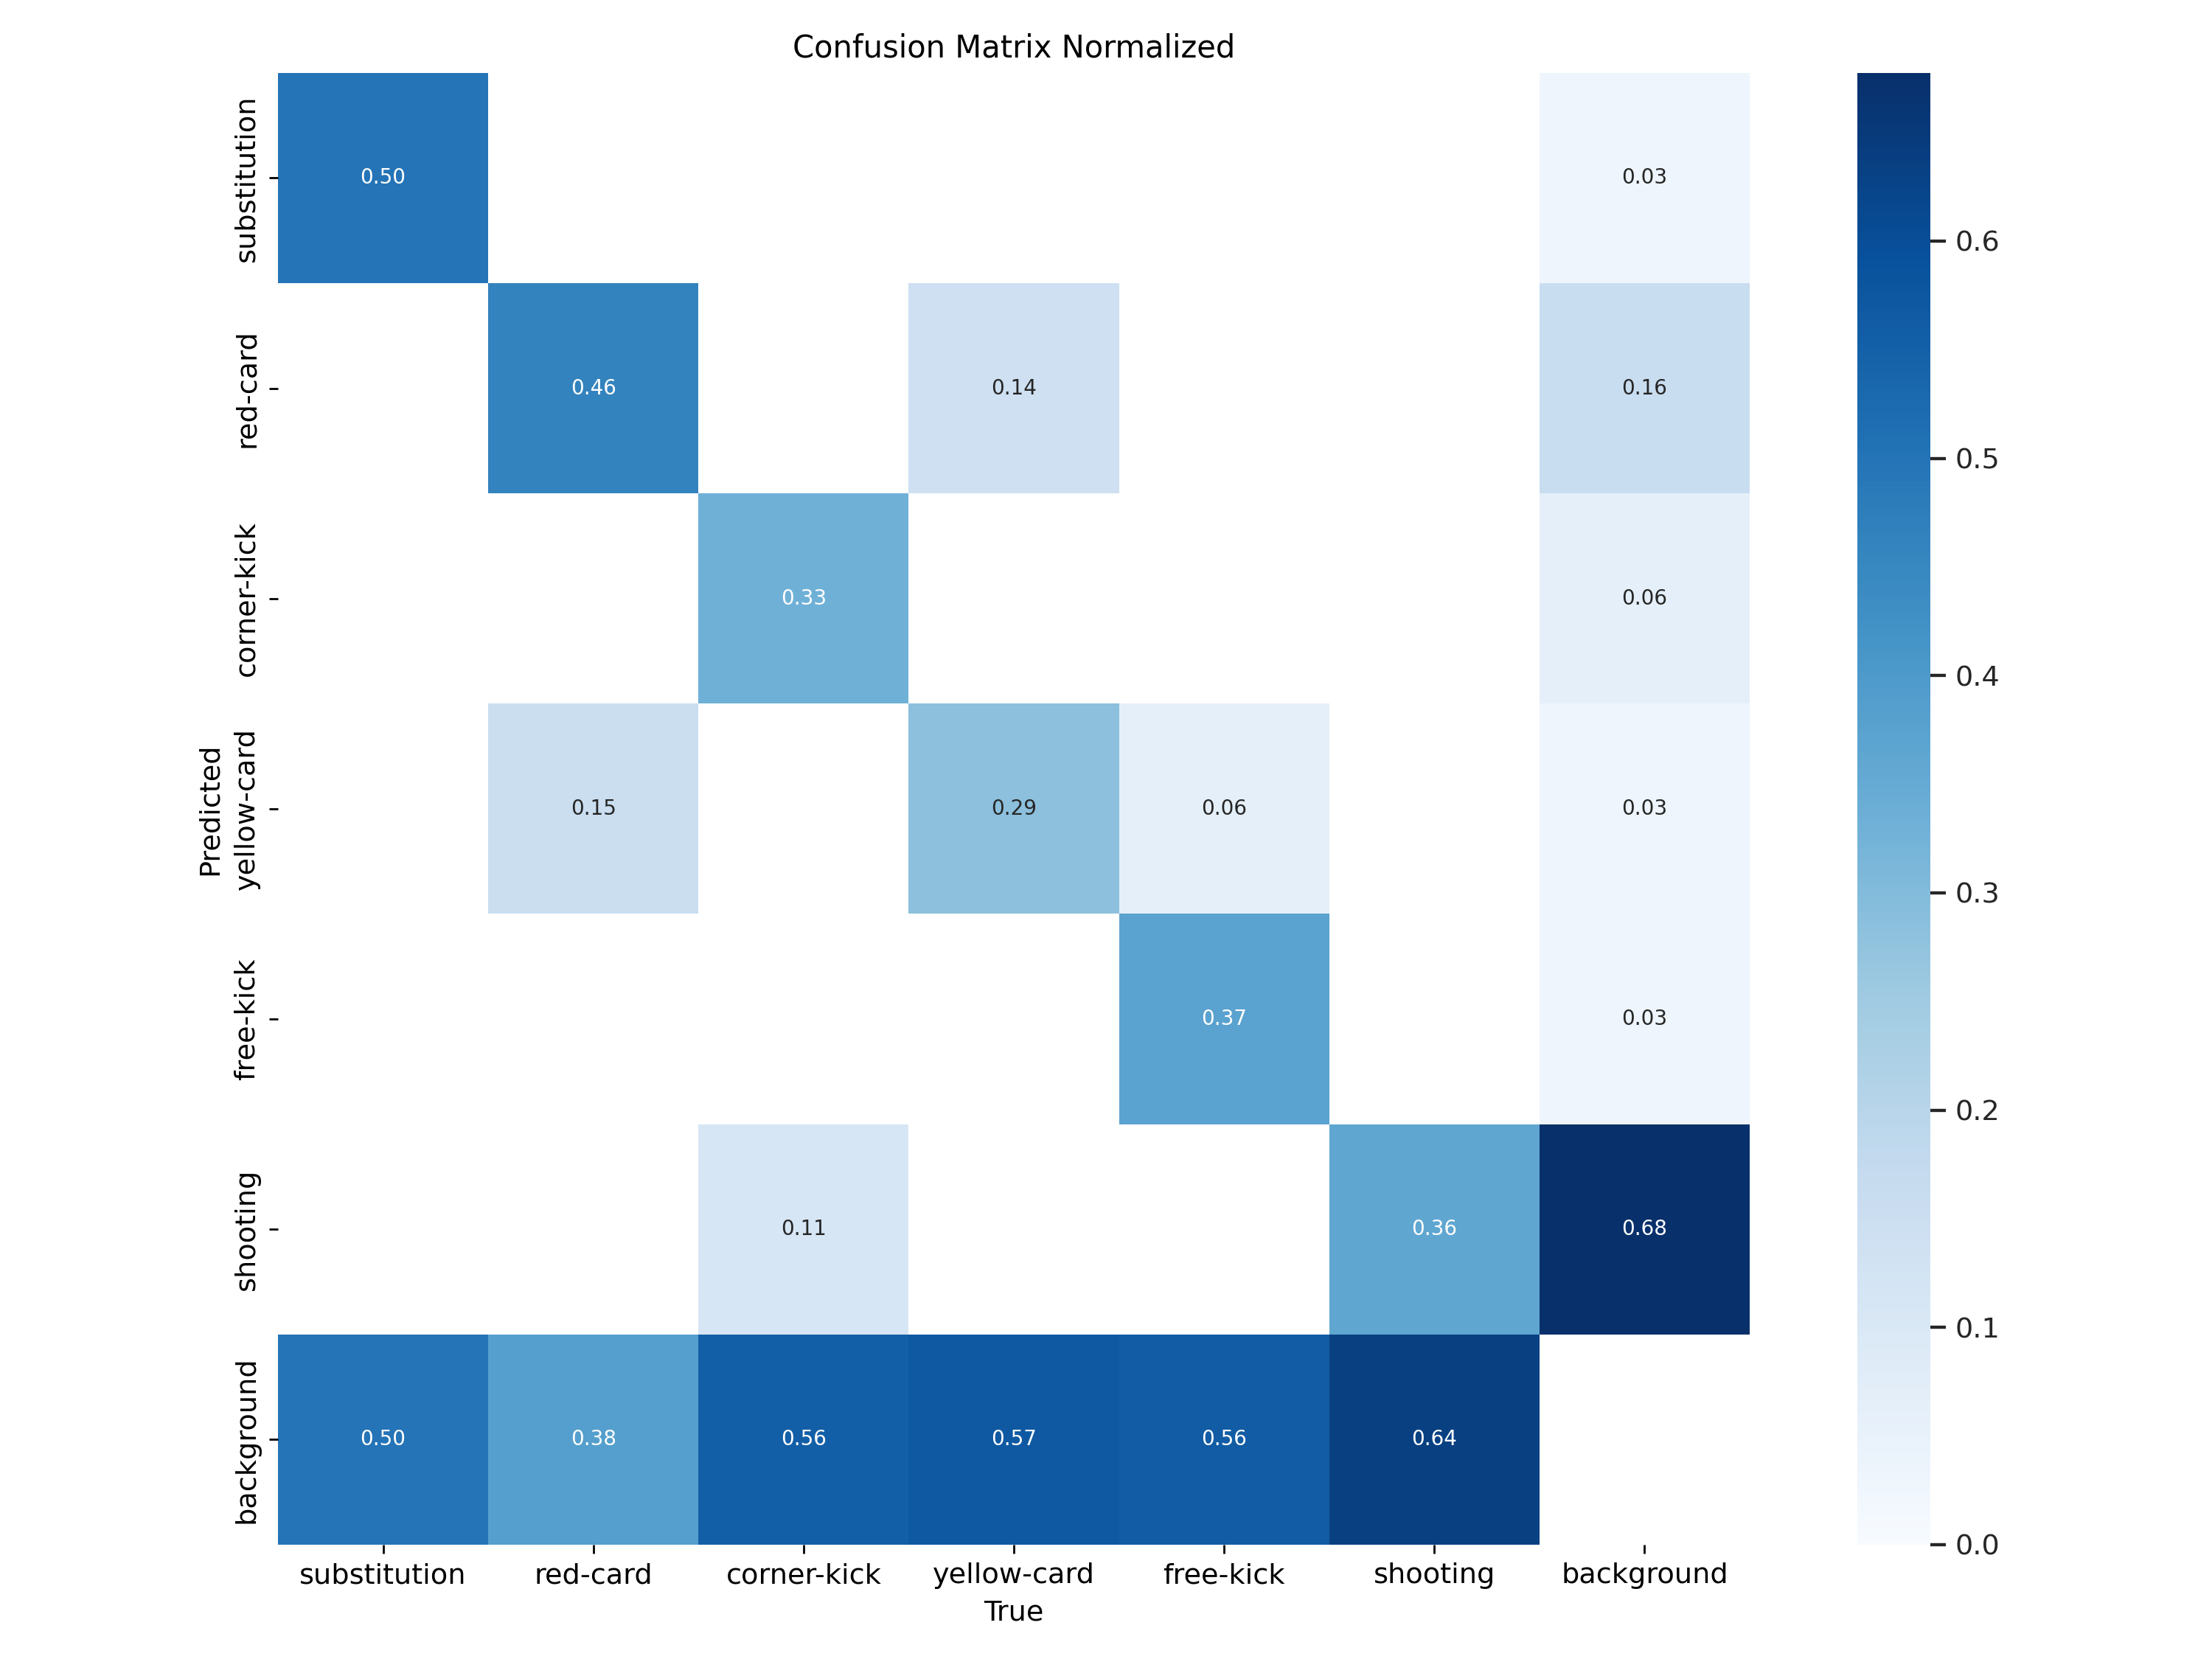

In [43]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train2/confusion_matrix_normalized.png')

##Prediction

In [45]:
model = YOLO('/content/runs/detect/train/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg', save=True)


Found https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg locally at Generic-referee-red-card-soccer.jpg
image 1/1 /content/Generic-referee-red-card-soccer.jpg: 384x640 (no detections), 62.1ms
Speed: 3.2ms preprocess, 62.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2


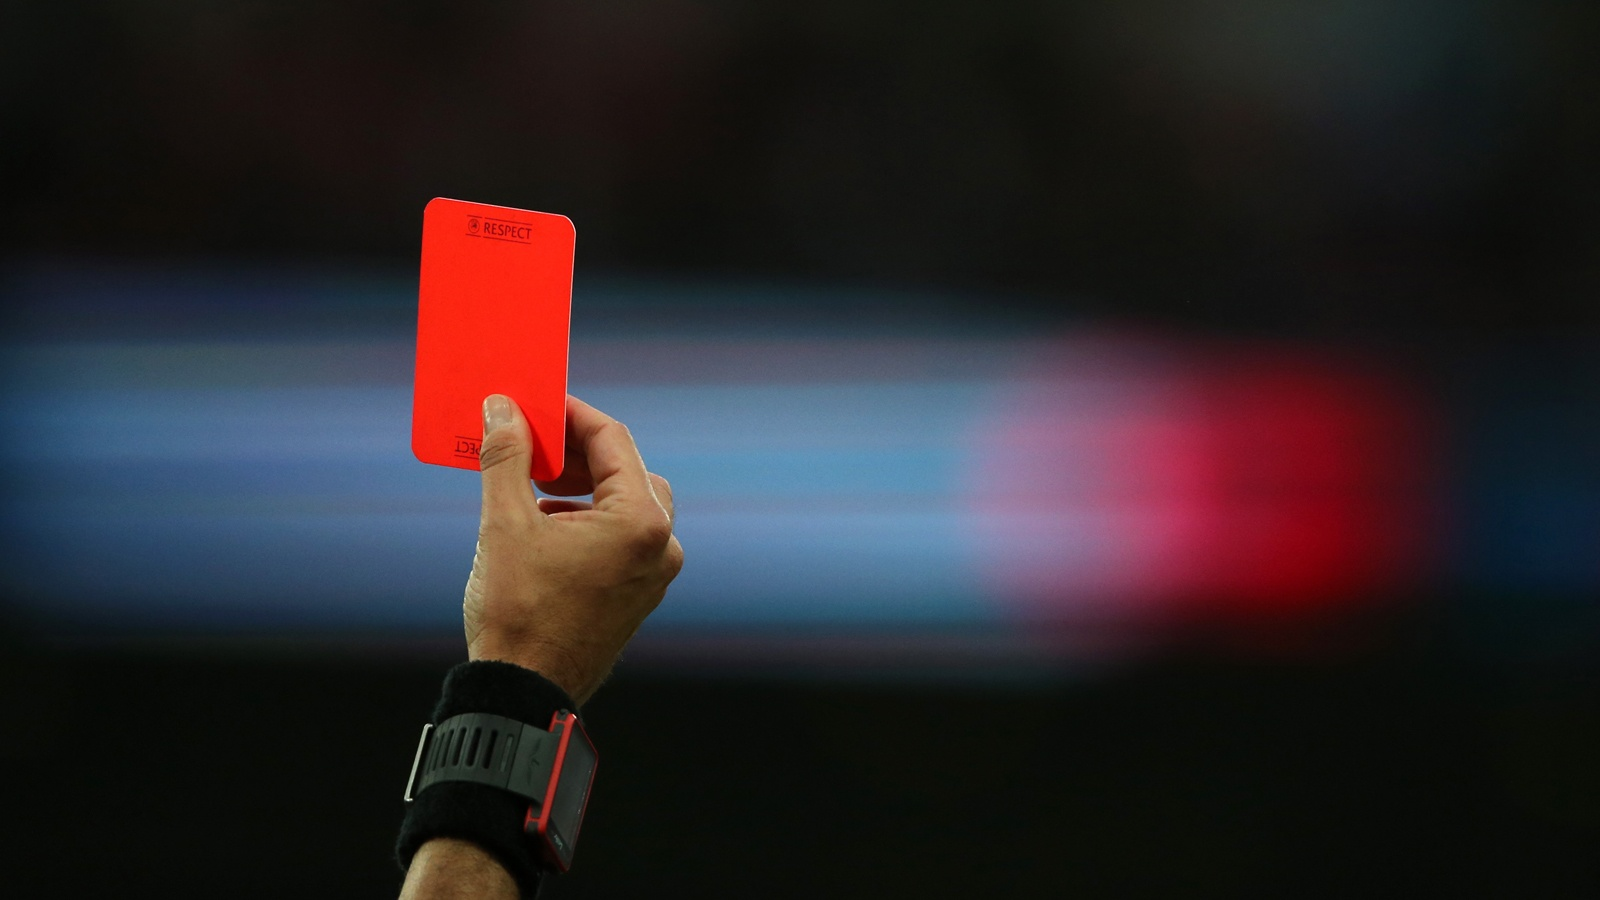

In [46]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict2/Generic-referee-red-card-soccer.jpg')

# Changing to 10 Epochs

In [48]:
model.train(data="config.yaml",epochs=10,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=config.yaml, epochs=10, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/train.cache... 519 images, 34 backgrounds, 0 corrupt: 100%|██████████| 553/553 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      7.64G      2.194      3.961      2.407          1        640: 100%|██████████| 70/70 [00:30<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


                   all         68         64      0.329      0.433      0.345      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      7.86G      1.907      3.173      2.136          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

                   all         68         64      0.349      0.561      0.406      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      7.88G      1.813      2.747      2.031          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

                   all         68         64      0.402      0.608      0.431      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      7.85G      1.747      2.522          2          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]

                   all         68         64      0.347       0.51       0.46      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      7.88G      1.628      2.345      1.942          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

                   all         68         64      0.483      0.438       0.51      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      7.86G        1.6      2.079      1.881          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all         68         64      0.526      0.611      0.521      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      7.87G      1.555      1.982      1.847          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all         68         64      0.623      0.531      0.628      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      7.34G      1.441      1.805       1.75          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all         68         64      0.596      0.543       0.64       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      7.32G        1.4      1.675      1.724          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]

                   all         68         64      0.718      0.648      0.738      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      7.32G      1.328      1.574      1.633          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

                   all         68         64      0.708      0.624      0.713      0.404



10 epochs completed in 0.096 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 87.7MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


                   all         68         64      0.706      0.625      0.713      0.404
          substitution         68          8      0.942      0.875      0.971      0.636
              red-card         68         13      0.651      0.923      0.824      0.458
           corner-kick         68          9      0.712      0.444      0.619      0.356
           yellow-card         68          7      0.597      0.429      0.517      0.207
             free-kick         68         16      0.578        0.5      0.545      0.366
              shooting         68         11      0.759      0.577      0.803      0.404
Speed: 0.5ms preprocess, 22.0ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7869ac95e110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [49]:
metrics = model.val()  # no arguments needed, dataset and settings remembered


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.06it/s]


                   all         68         64      0.707      0.625      0.713      0.406
          substitution         68          8      0.942      0.875      0.971      0.636
              red-card         68         13      0.651      0.923      0.824      0.453
           corner-kick         68          9      0.713      0.444      0.618      0.355
           yellow-card         68          7      0.597      0.429      0.517      0.219
             free-kick         68         16      0.578        0.5      0.547      0.367
              shooting         68         11      0.759      0.576      0.803      0.405
Speed: 0.5ms preprocess, 40.8ms inference, 0.3ms loss, 5.5ms postprocess per image
Results saved to runs/detect/train42


In [50]:
metrics.box.map    # map50-95

0.40608101047677253

In [51]:
metrics.box.map50  # map50

0.7133673483887876

In [52]:
metrics.box.map75  # map75

0.39974731913005623

In [53]:
metrics.box.maps   # a list contains map50-95 of each category

array([    0.63619,     0.45334,     0.35538,     0.21934,      0.3672,     0.40504])

In [54]:
metrics.box.mp    # P

0.7067726058268283

In [55]:
metrics.box.mr    # R

0.6245619385844198

Showing confusion matrix, that is already stored in detect/train folder

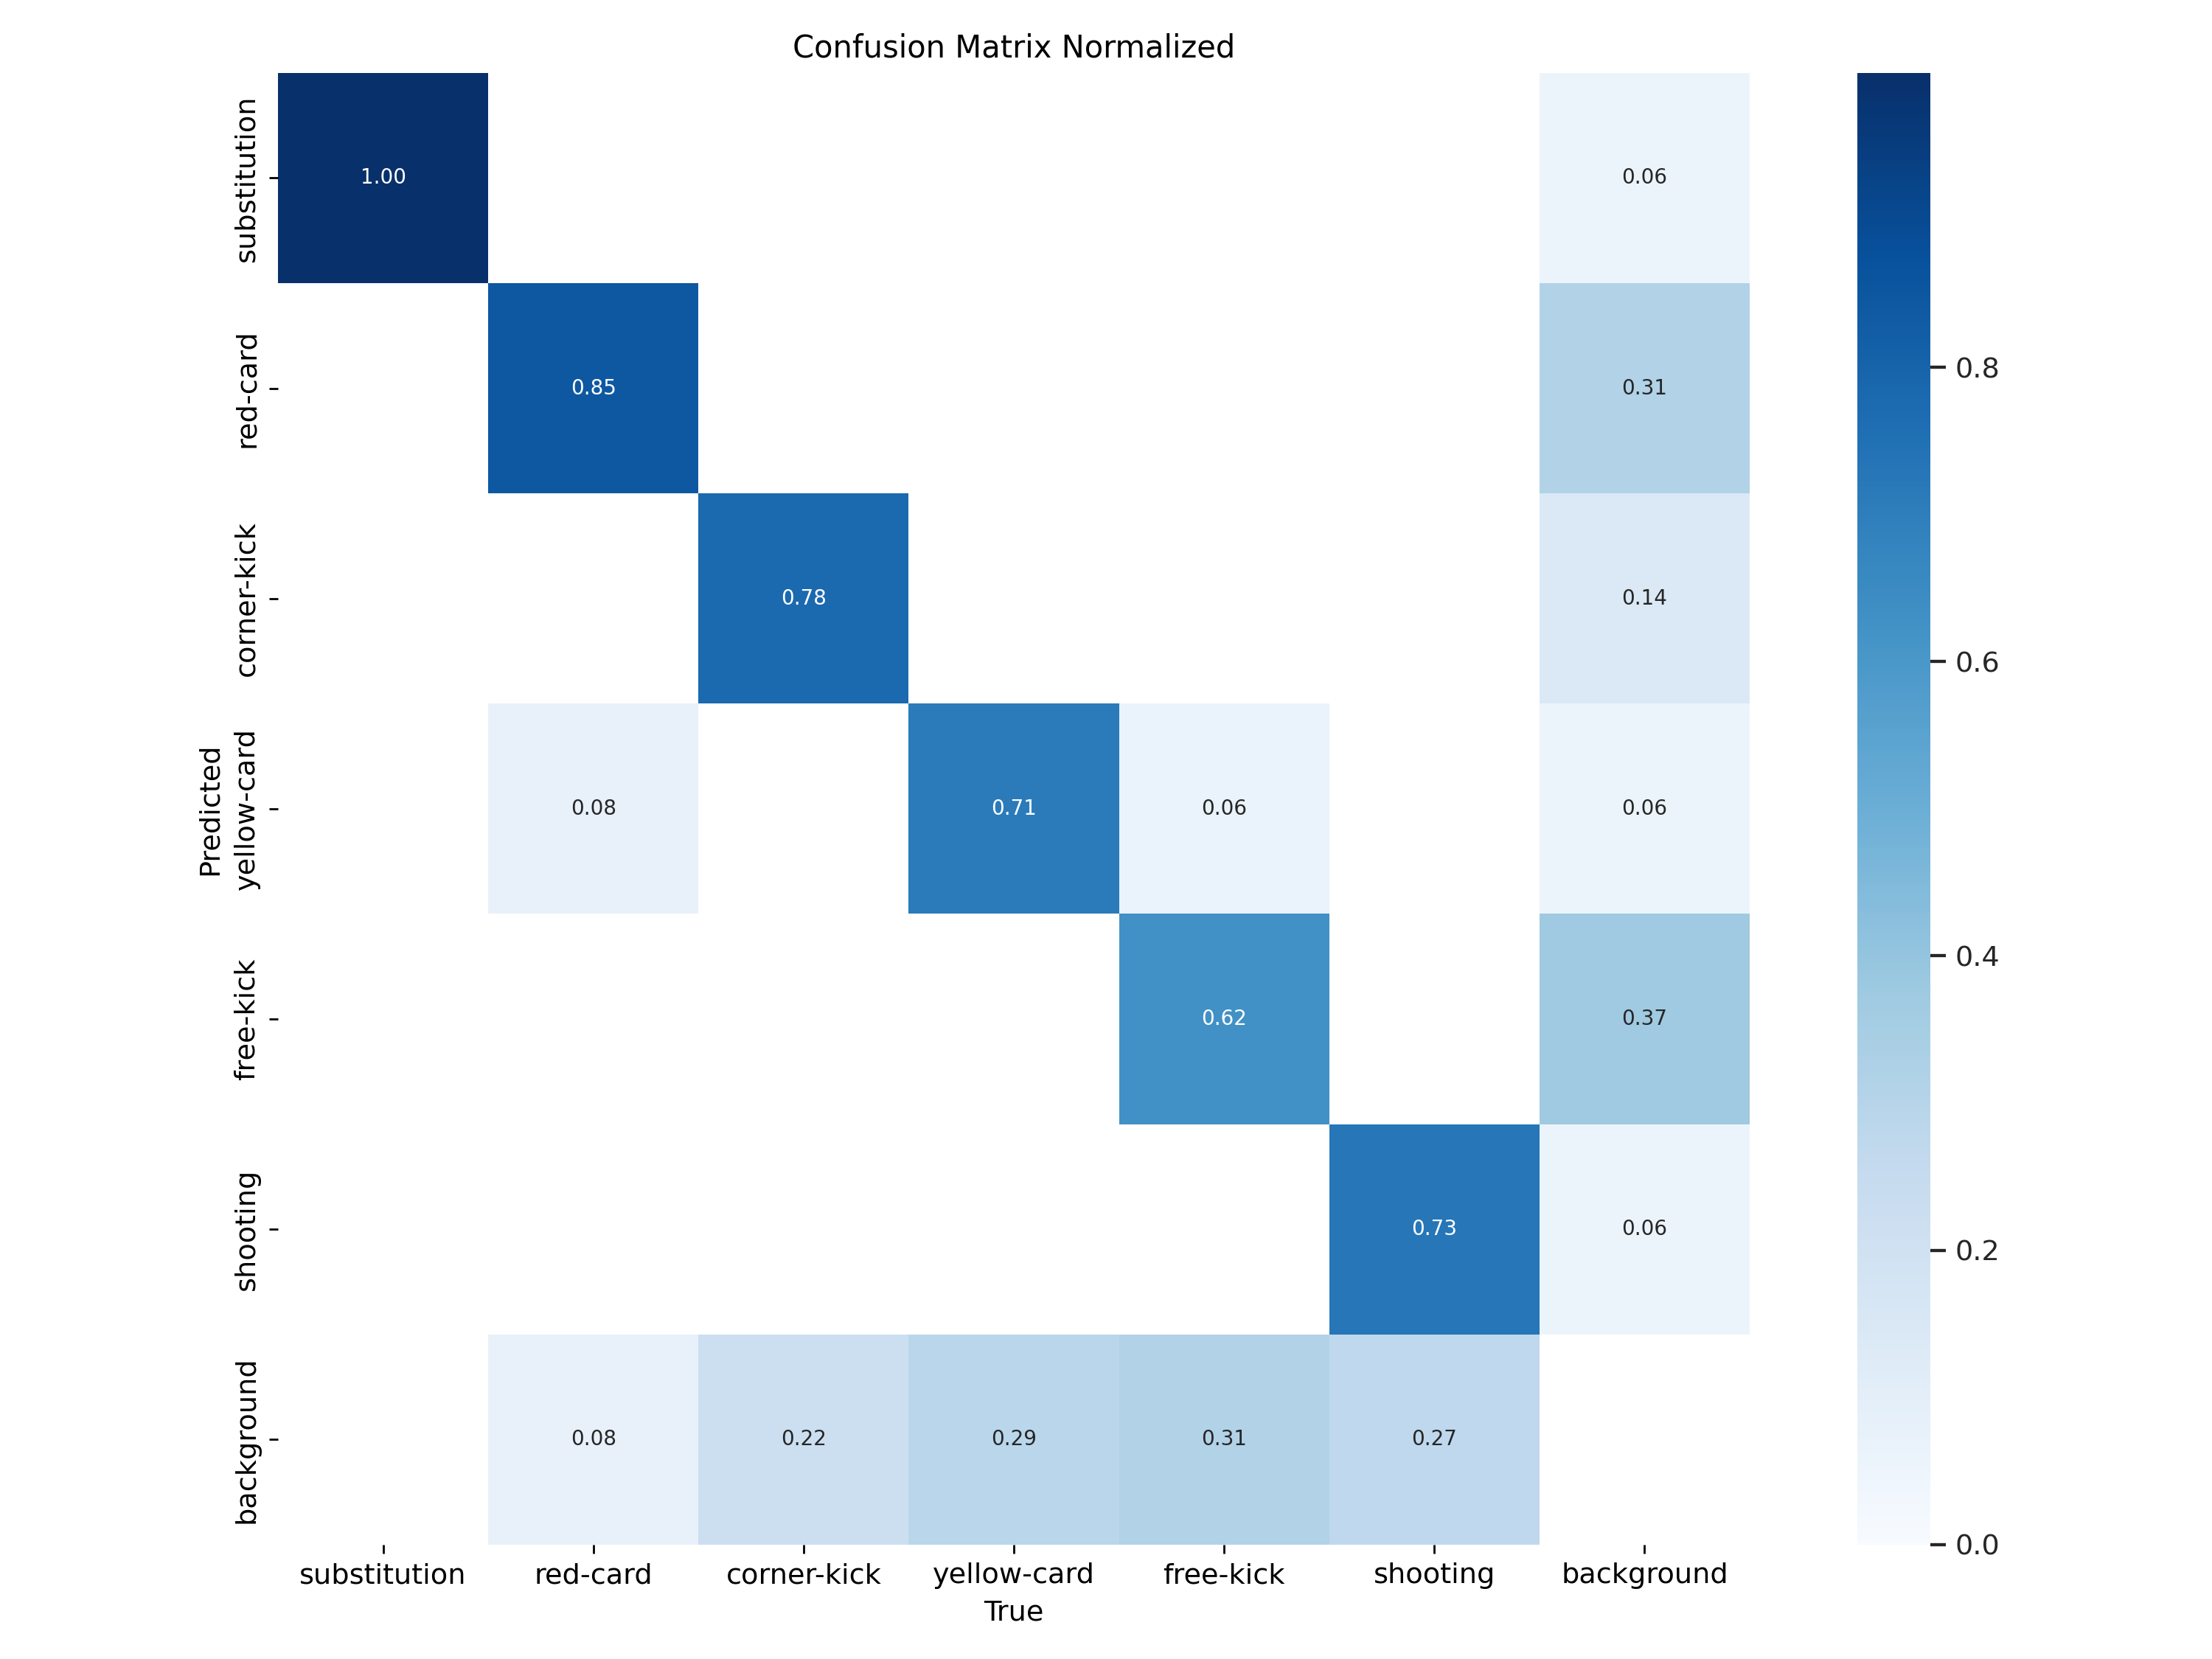

In [56]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train4/confusion_matrix_normalized.png')

##Prediction

In [59]:
model = YOLO('/content/runs/detect/train4/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg', save=True)


Found https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg locally at Generic-referee-red-card-soccer.jpg
image 1/1 /content/Generic-referee-red-card-soccer.jpg: 384x640 1 yellow-card, 41.4ms
Speed: 3.4ms preprocess, 41.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4


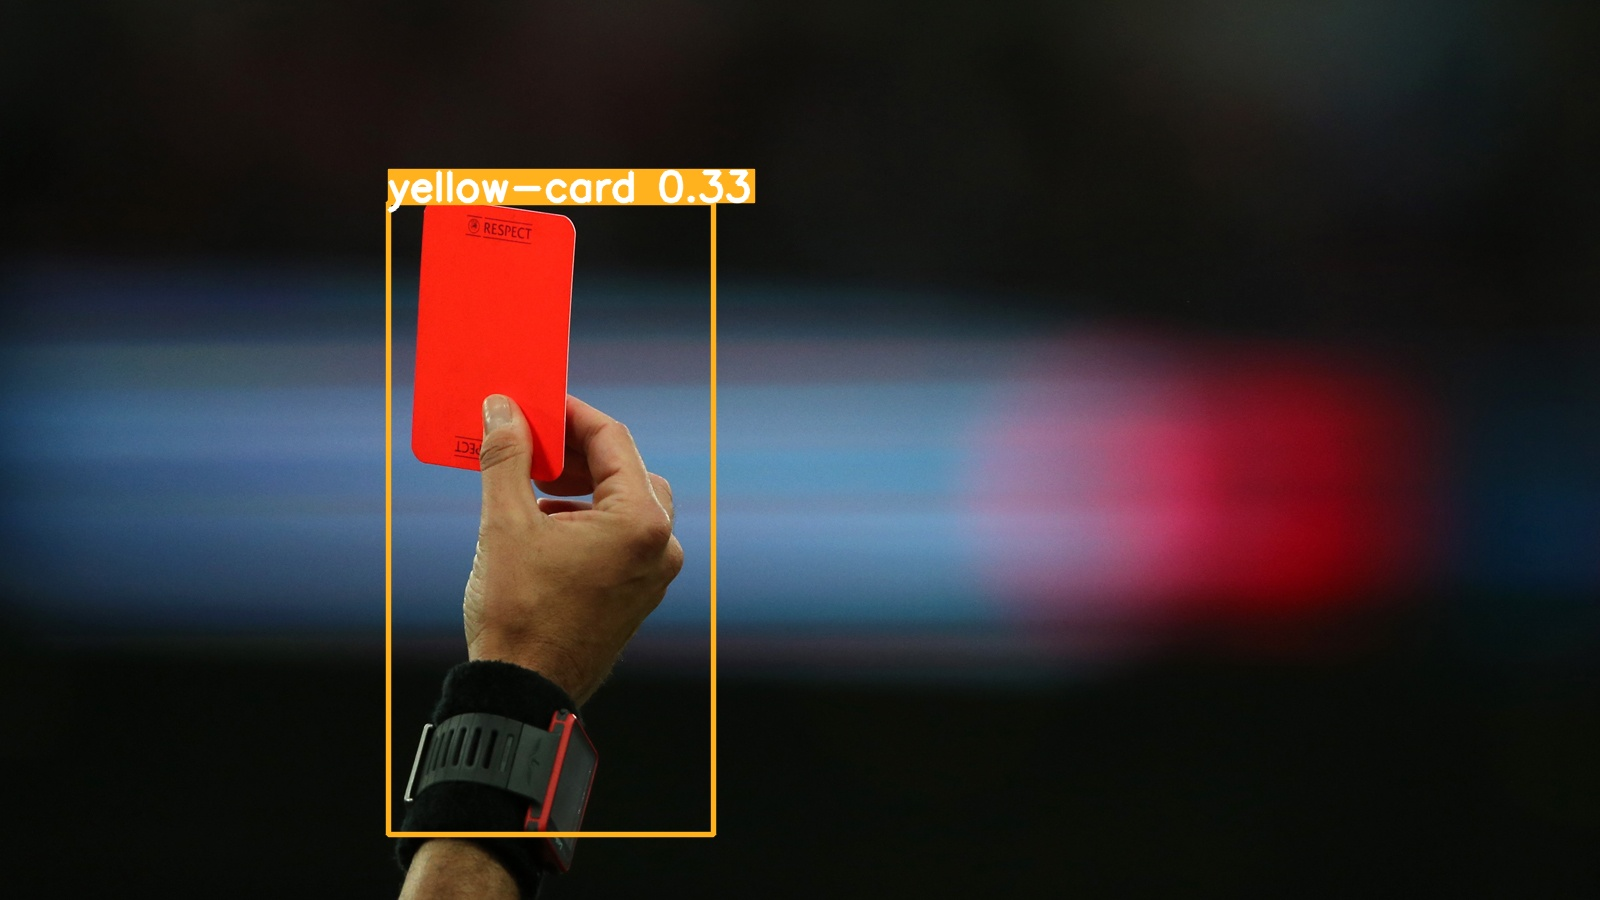

In [61]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict4/Generic-referee-red-card-soccer.jpg')

# Changing to 15 Epochs

In [62]:
model.train(data="config.yaml",epochs=15,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train4/weights/best.pt, data=config.yaml, epochs=15, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

train: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/train.cache... 519 images, 34 backgrounds, 0 corrupt: 100%|██████████| 553/553 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      8.91G      1.614      2.092      1.801          2        640: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

                   all         68         64      0.438      0.576       0.49      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      9.12G      1.613      2.053      1.815          3        640: 100%|██████████| 70/70 [00:29<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all         68         64      0.645       0.35      0.476      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      9.14G      1.632      2.244      1.876          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

                   all         68         64      0.446      0.405      0.404      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      9.11G       1.62       2.17      1.857          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]

                   all         68         64      0.523      0.481      0.527      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      9.14G      1.552      1.979      1.805          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all         68         64      0.479      0.539      0.558      0.307


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      9.12G      1.518      1.841      1.792          1        640: 100%|██████████| 70/70 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

                   all         68         64      0.508      0.548      0.522      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      9.12G      1.513       1.78      1.805          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

                   all         68         64      0.578       0.61      0.644      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      9.11G      1.422      1.608      1.726          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

                   all         68         64      0.562      0.715      0.667      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      9.14G      1.418      1.511       1.68          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

                   all         68         64      0.653      0.561      0.628      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      8.58G      1.345       1.48      1.653          1        640: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

                   all         68         64      0.601      0.754      0.711      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      8.57G      1.336      1.394      1.632          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

                   all         68         64        0.6      0.629      0.612      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      8.56G      1.224      1.344      1.562          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

                   all         68         64      0.647      0.785      0.749      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      8.57G      1.185      1.165      1.536          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

                   all         68         64      0.672      0.703      0.762      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      8.57G      1.204      1.207      1.531          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

                   all         68         64      0.718      0.693      0.785      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      8.55G      1.103      1.138      1.447          1        640: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

                   all         68         64      0.704      0.738      0.792      0.485



15 epochs completed in 0.197 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 87.7MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 87.7MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


                   all         68         64      0.704      0.745      0.793      0.488
          substitution         68          8      0.857          1      0.995      0.731
              red-card         68         13      0.738      0.923      0.911      0.499
           corner-kick         68          9      0.524      0.493      0.589      0.417
           yellow-card         68          7      0.715      0.857      0.819       0.35
             free-kick         68         16       0.44      0.562       0.58       0.38
              shooting         68         11      0.951      0.636      0.863      0.548
Speed: 0.4ms preprocess, 20.9ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7869a7373190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [63]:
metrics = model.val()  # no arguments needed, dataset and settings remembered


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43611234 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/drive/MyDrive/FootballEvents3/Final_data/labels/val.cache... 63 images, 5 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


                   all         68         64      0.704      0.738      0.793      0.486
          substitution         68          8      0.859          1      0.995      0.731
              red-card         68         13      0.745      0.923      0.911      0.499
           corner-kick         68          9      0.502      0.449      0.587      0.417
           yellow-card         68          7      0.718      0.857      0.819      0.336
             free-kick         68         16      0.444      0.562      0.576      0.382
              shooting         68         11      0.955      0.636      0.869       0.55
Speed: 1.6ms preprocess, 42.8ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/train52


In [64]:
metrics.box.map    # map50-95

0.4858837874141705

In [65]:
metrics.box.map50  # map50

0.792818027157451

In [66]:
metrics.box.map75  # map75

0.4930746274781075

In [67]:
metrics.box.maps   # a list contains map50-95 of each category

array([    0.73058,     0.49928,     0.41704,     0.33624,     0.38204,     0.55012])

In [69]:
metrics.box.mp    # P

0.7037303962128991

In [70]:
metrics.box.mr    # R

0.7379847363197344

Showing confusion matrix, that is already stored in detect/train folder

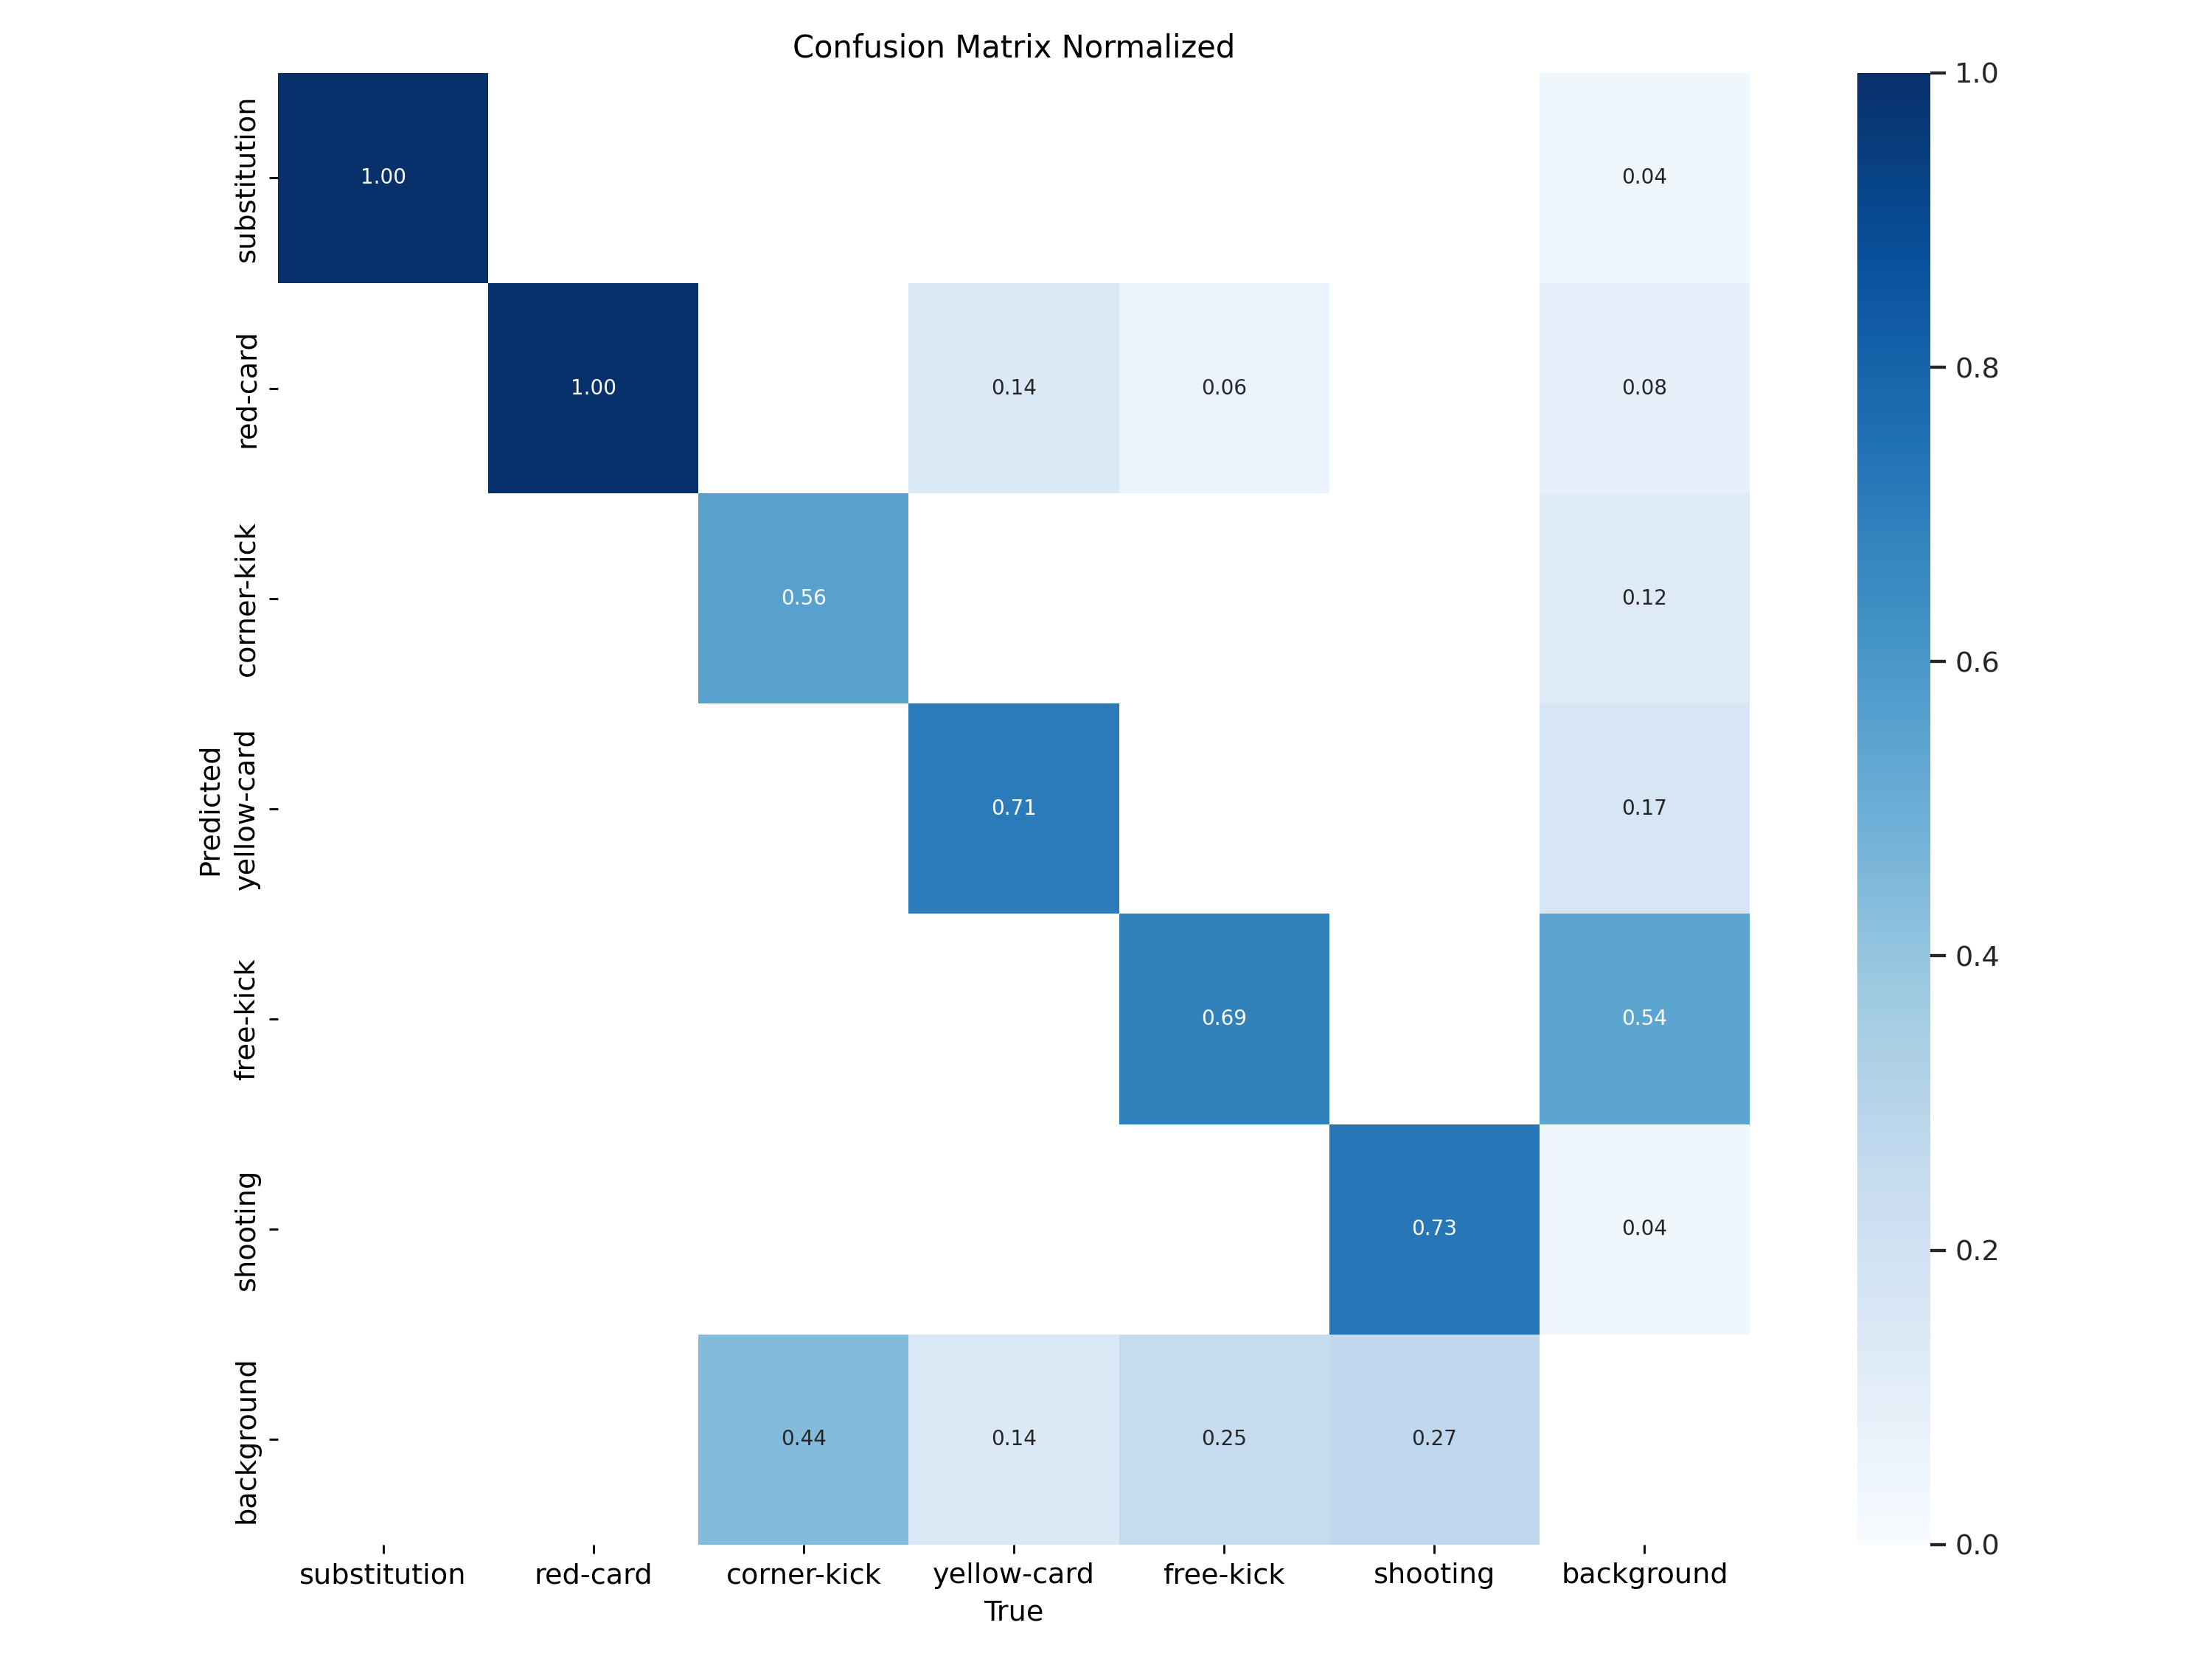

In [71]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train5/confusion_matrix_normalized.png')

##Prediction

In [72]:
model = YOLO('/content/runs/detect/train5/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg', save=True)


Found https://statathlon.com/wp-content/uploads/2017/11/Generic-referee-red-card-soccer.jpg locally at Generic-referee-red-card-soccer.jpg
image 1/1 /content/Generic-referee-red-card-soccer.jpg: 384x640 1 red-card, 41.9ms
Speed: 3.5ms preprocess, 41.9ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict5


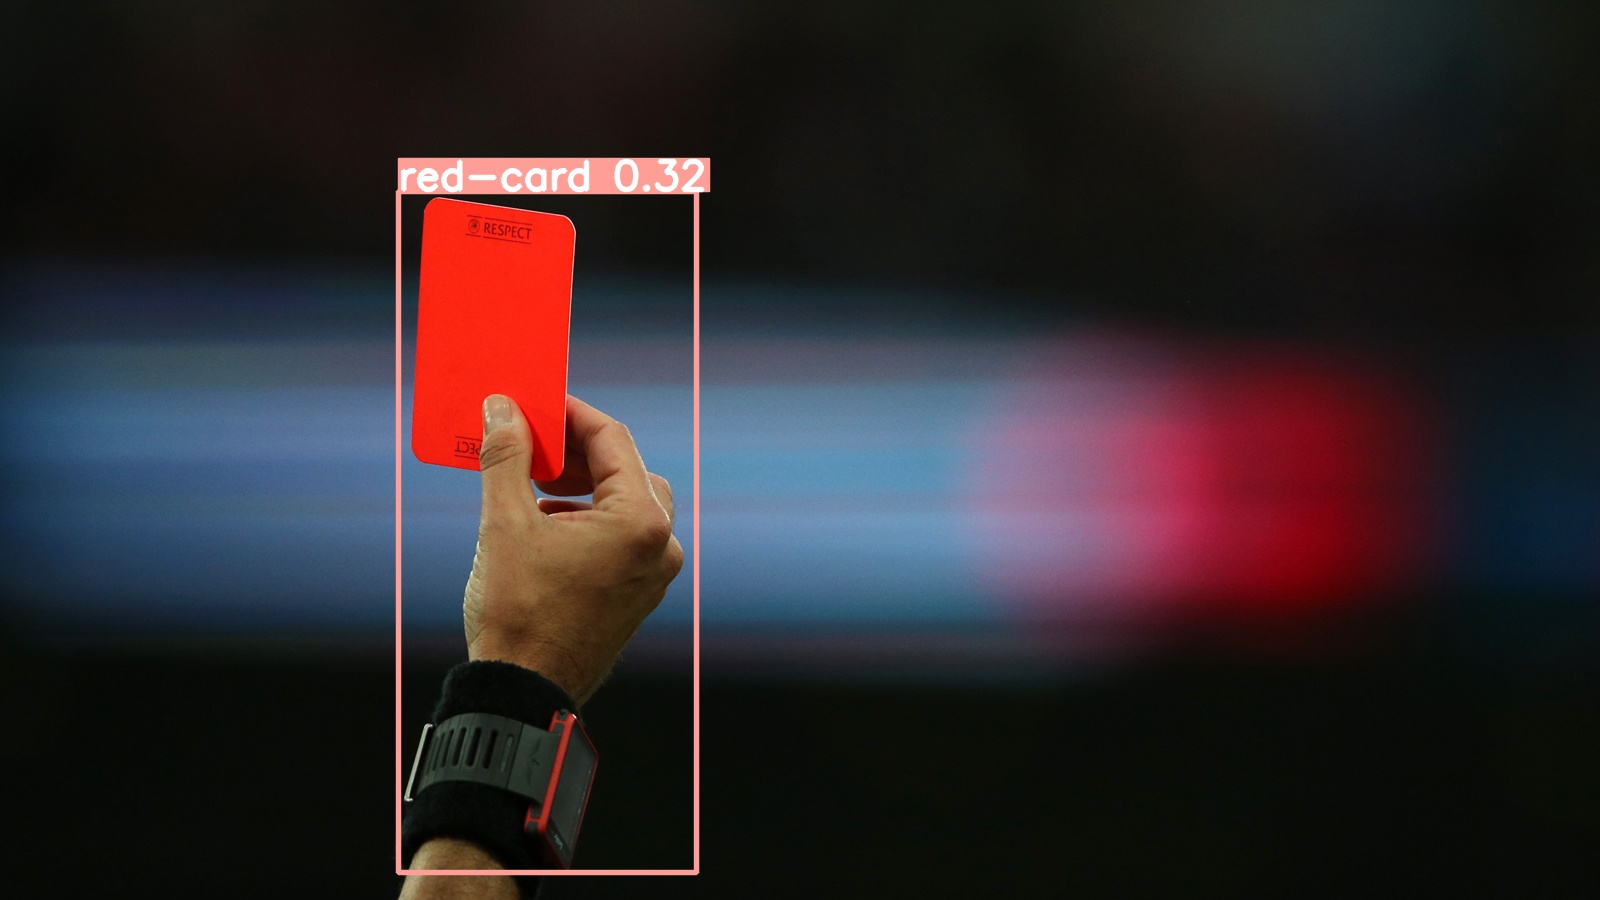

In [73]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict5/Generic-referee-red-card-soccer.jpg')